In [1]:
import torch
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os
image_path = os.path.join(os.getcwd(), "cifar10")
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

# Dataloading Operations 

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
IMG_SIZE = 32
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           

Manually created transforms: Compose(
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [6]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms) #first arg as directory address
test_data = datasets.ImageFolder(test_dir, transform=manual_transforms)

In [7]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [22]:
batch_size = 512

In [23]:
class_names = train_data.classes

train_dataloader = DataLoader(
train_data,
batch_size=batch_size,
shuffle=True,
num_workers=os.cpu_count(),
pin_memory=True,
)
test_dataloader = DataLoader(
test_data,
batch_size=batch_size,
shuffle=False,
num_workers=os.cpu_count(),
pin_memory=True,
)

# PATCH EMBEDDING CLASSES

In [24]:
class PatchEmbedding(nn.Module):
    
    def __init__(self,img_size,patch_size,in_channel = 3,emb_size = 768):
        
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.nf_patch = (img_size//patch_size)**2 
        self.proj = nn.Conv2d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size)       #768 feature maps  
        
    def forward(self,x):
        x = x.float()        
        x = self.proj(x) 
        x = x.flatten(2)        
        x=x.transpose(1,2)
        
        return x

In [25]:
class PatchEmbeddingOverlapping(nn.Module):
    
    def __init__(self,img_size,patch_size,in_channel = 3,emb_size = 768):
        
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.stride = patch_size // 2   # Set stride for overlapping patches
        self.nf_patch = ((img_size - patch_size) // self.stride + 1) ** 2 
        self.proj = nn.Conv2d(in_channel, emb_size, kernel_size=patch_size, stride=self.stride)    
        
    def forward(self,x):
        x = x.float()
        x = self.proj(x) 
        x = x.flatten(2)
        
        x = x.transpose(1,2)
        
        return x


# ATTENTION CLASS

In [26]:
class Attention(nn.Module):
    def __init__(self,dim,num_head ):
        super().__init__()
        self.num_head = num_head
        self.dim= dim
        self.head_dim = dim // num_head
        self.q_linear = nn.Linear(dim, dim)
        self.k_linear = nn.Linear(dim, dim)
        self.v_linear = nn.Linear(dim, dim) 
        
    def forward(self,x):
        n_sample, n_patch , dim = x.shape
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)

        Q = Q.view(n_sample, -1, self.num_head, self.head_dim)
        K = K.view(n_sample, -1, self.num_head, self.head_dim)
        V = V.view(n_sample, -1, self.num_head, self.head_dim)
        
        Q = Q.transpose(1,2)
        K = K.transpose(1,2)
        V = V.transpose(1,2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        atten_matrix = torch.softmax(scores,dim =-1)
        attn_output = torch.matmul(atten_matrix, V)
        attn_output = attn_output.transpose(1,2).flatten(2)

        return attn_output

# MLP CLASS

In [27]:
class MLP(nn.Module):
    def __init__(self, emb_size: int, expansion: int = 4):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, expansion * emb_size)
        self.fc2 = nn.GELU()
        self.fc3 = nn.Linear(expansion * emb_size, emb_size)
            
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# RESIDUAL BLOCK

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self,dim,num_head  ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim , eps = 1e-7)
        self.atten = Attention(dim , num_head)
        self.norm2 = nn.LayerNorm(dim, eps = 1e-6)
        self.mlp = MLP(dim )
        
    def forward(self, x):
        x = x + self.atten(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
            

# Experiment 1

### Defining VISION TRANSFORMER class

In [29]:
class VisionTransFormer(nn.Module):
    def __init__(self,img_size , patch_size, in_channel , emb_size  ,num_head , overlap):
        super().__init__()
        if overlap:
            self.patchEmb = PatchEmbeddingOverlapping( img_size,patch_size,in_channel , emb_size)
        else:
            self.patchEmb = PatchEmbedding( img_size,patch_size,in_channel , emb_size)

        self.cls_token = nn.Parameter(torch.zeros(1,1,emb_size))
        self.blocks = nn.ModuleList(
            [
                ResidualBlock(dim = emb_size , num_head = num_head)
                for _ in range(4)
            ]
        )
        self.pos_emb = nn.Parameter(
            torch.zeros(1,1+self.patchEmb.nf_patch ,emb_size)
        )
        self.norm = nn.LayerNorm(emb_size , eps = 1e-6)
        self.head = nn.Sequential(
            nn.Linear(emb_size, 10), 
            nn.Tanh()
        )
        
    def forward(self,x):
        n_sample = x.shape[0]
        x = self.patchEmb(x)
        cls_token = self.cls_token.expand(n_sample,-1,-1)
        
        x = torch.cat((cls_token,x),dim=1)
        x = x + self.pos_emb
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        cls_token_final = x[:,0]
        x = self.head(cls_token_final)
        return x

# Experiment 2

### With Overlapping Patches

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list_patchwise = []
train_acc_list_patchwise = []
test_acc_list_patchwise = []
test_loss_list_patchwise = []

patch_list = [4,8,16]

for patch in patch_list:
  
  model = VisionTransFormer(32,patch,3,768,12,True).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)
  
  train_loss_list = []
  train_acc_list = [] 
  
  train_loss = 0
  train_acc = 0 
  

  for epochs in range(30):
    for batch, (X, y) in enumerate(train_dataloader):
      X, y = X.to(device), y.to(device)
      
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
      
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
  loss_list_patchwise.append(train_loss_list)
  train_acc_list_patchwise.append(train_acc_list)
  
  test_loss = 0
  test_acc = 0

  model.eval() 

  with torch.no_grad(): 
    for batch, (X, y) in enumerate(test_dataloader):

      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item() 

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)            

  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)
  
  test_acc_list_patchwise.append(test_acc)
  test_loss_list_patchwise.append(test_loss)


### PLOTS

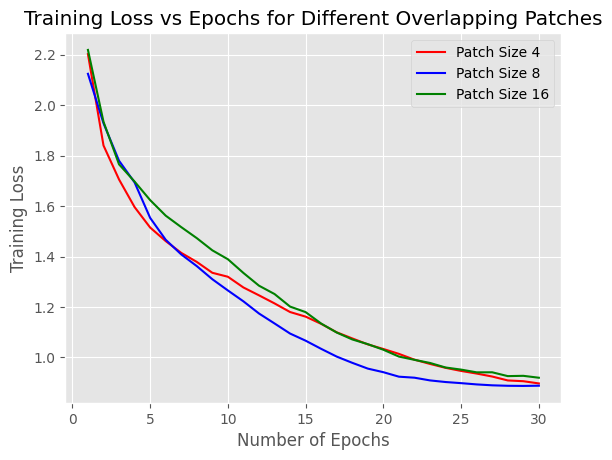

In [31]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
colors = ['r', 'b', 'g', 'c']

epochs = range(1, 31)

for i in range(len(patch_list)):
  plt.plot(epochs, loss_list_patchwise[i], label=f'Patch Size {patch_list[i]}', color=colors[i])

plt.title('Training Loss vs Epochs for Different Overlapping Patches')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.legend()

plt.show()

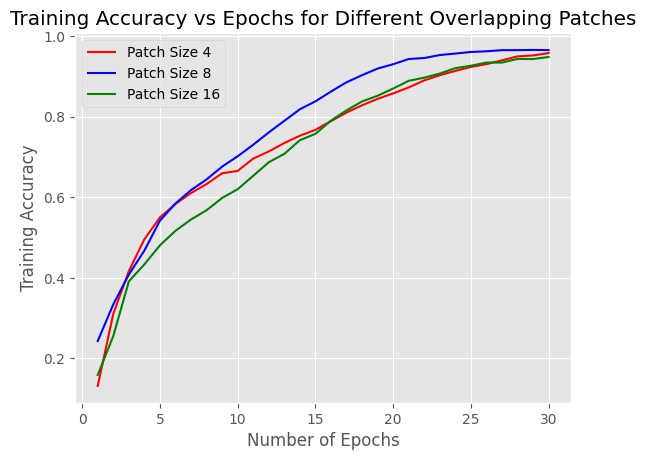

In [32]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
colors = ['r', 'b', 'g', 'c']

epochs = range(1, 31)

for i in range(len(patch_list)):
  plt.plot(epochs, train_acc_list_patchwise[i], label=f'Patch Size {patch_list[i]}', color=colors[i])

plt.title('Training Accuracy vs Epochs for Different Overlapping Patches')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.legend()

plt.show()


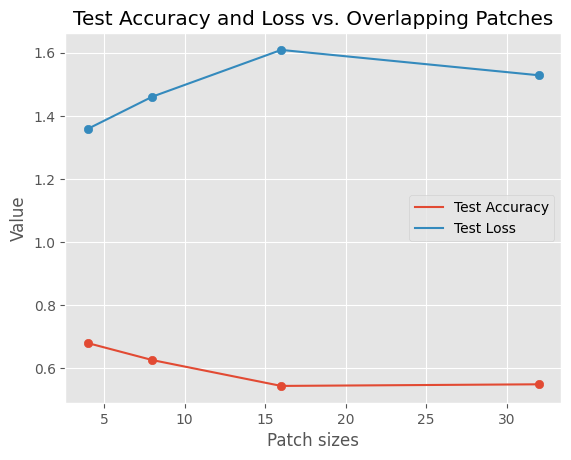

In [24]:


plt.scatter(patch_list, test_acc_list_patchwise)
plt.scatter(patch_list, test_loss_list_patchwise)
plt.plot(patch_list, test_acc_list_patchwise, label='Test Accuracy')
plt.plot(patch_list, test_loss_list_patchwise, label='Test Loss')
plt.xlabel('Patch sizes')
plt.ylabel('Value')
plt.title('Test Accuracy and Loss vs. Overlapping Patches')
plt.legend()
plt.show()

### With non-overlapping patches

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list_patchwise = []
train_acc_list_patchwise = []
test_acc_list_patchwise = []
test_loss_list_patchwise = []

patch_list = [4,8,16]

for patch in patch_list:
  
  model = VisionTransFormer(32,patch,3,768,12,False).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  
  train_loss_list = []
  train_acc_list = [] 
  
  train_loss = 0
  train_acc = 0 
  

  for epochs in range(25):
    for batch, (X, y) in enumerate(train_dataloader):

      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      optimizer.zero_grad()

      loss.backward()

    
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
  loss_list_patchwise.append(train_loss_list)
  train_acc_list_patchwise.append(train_acc_list)
  
  test_loss = 0
  test_acc = 0

  model.eval() 

  with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
      
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item() 

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)            

  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)
  
  test_acc_list_patchwise.append(test_acc)
  test_loss_list_patchwise.append(test_loss)
    

# PLOTS

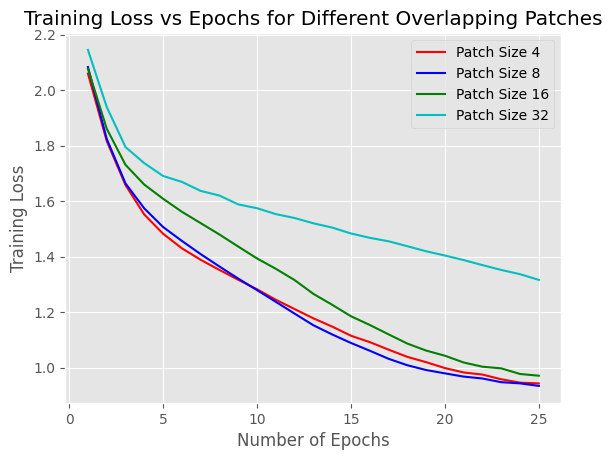

In [32]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
colors = ['r', 'b', 'g', 'c', 'm']

epochs = range(1, 26)

for i in range(len(patch_list)):
  plt.plot(epochs, loss_list_patchwise[i], label=f'Patch Size {patch_list[i]}', color=colors[i])

plt.title('Training Loss vs Epochs for Different Non-Overlapping Patches')
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.legend()

plt.show()


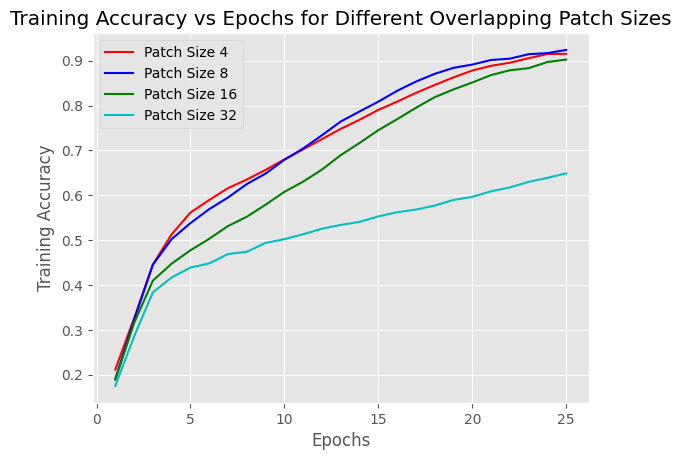

In [33]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
colors = ['r', 'b', 'g', 'c', 'm']

epochs = range(1, 26)

for i in range(len(patch_list)):
  plt.plot(epochs, train_acc_list_patchwise[i], label=f'Patch Size {patch_list[i]}', color=colors[i])

plt.title('Training Accuracy vs Epochs for Different Non-Overlapping Patch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()

plt.show()


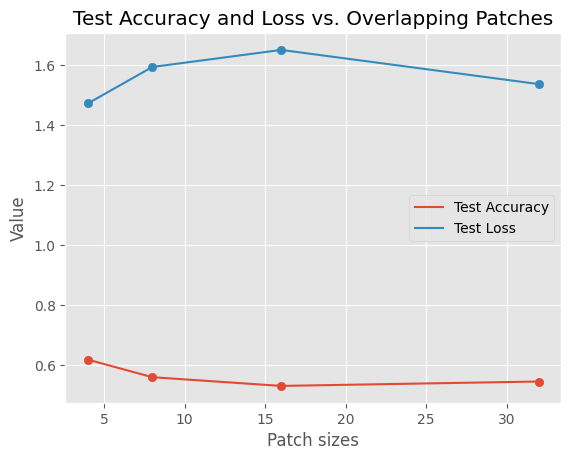

In [34]:
plt.scatter(patch_list, test_acc_list_patchwise)
plt.scatter(patch_list, test_loss_list_patchwise)
plt.plot(patch_list, test_acc_list_patchwise, label='Test Accuracy')
plt.plot(patch_list, test_loss_list_patchwise, label='Test Loss')
plt.xlabel('Patch sizes')
plt.ylabel('Value')
plt.title('Test Accuracy and Loss vs. Non-Overlapping Patches')
plt.legend()
plt.show()

# Experiment 3

### Varying the number of Attention Heads

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_list_headwise = []
train_acc_list_headwise = []
test_acc_list_headwise = []
test_loss_list_headwise = []

head_list = [4,8,12]

for head in head_list:
  
  model = VisionTransFormer(32,16,3,768,head,False).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00009)
  
  train_loss_list = []
  train_acc_list = [] 
  
  train_loss = 0
  train_acc = 0 
  

  for epochs in range(30):
    for batch, (X, y) in enumerate(train_dataloader):
      
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
 
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
  loss_list_headwise.append(train_loss_list)
  train_acc_list_headwise.append(train_acc_list)
  
  
  test_loss = 0
  test_acc = 0

  model.eval() 

  with torch.no_grad(): 
    for batch, (X, y) in enumerate(test_dataloader):
    
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item() 

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)            

  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)
  
  test_acc_list_headwise.append(test_acc)
  test_loss_list_headwise.append(test_loss)


### PLOTS

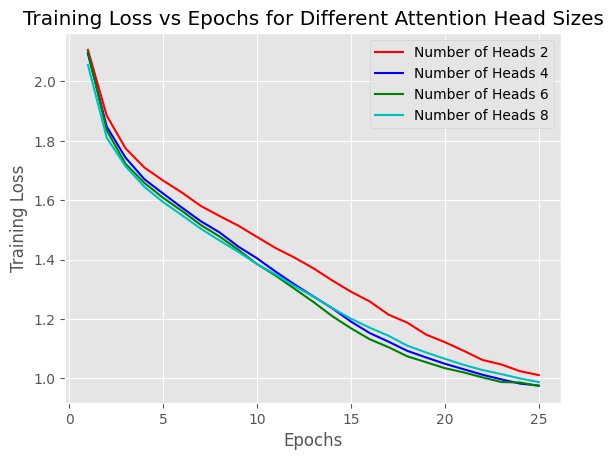

In [41]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
colors = ['r', 'b', 'g', 'c', 'm']

epochs = range(1, 26)

for i in range(len(patch_list)):
  plt.plot(epochs, loss_list_headwise[i], label=f'Number of Heads {head_list[i]}', color=colors[i])

plt.title('Training Loss vs Epochs for Different Attention Head Sizes')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

plt.show()


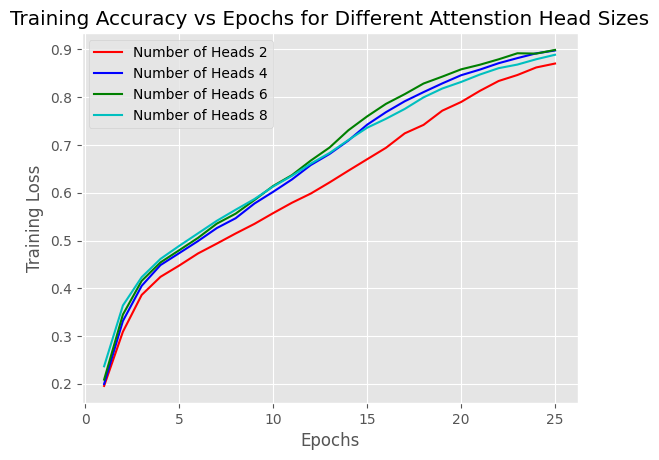

In [42]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
colors = ['r', 'b', 'g', 'c', 'm']

epochs = range(1, 26)

for i in range(len(patch_list)):
  plt.plot(epochs, train_acc_list_headwise[i], label=f'Number of Heads {head_list[i]}', color=colors[i])

plt.title('Training Accuracy vs Epochs for Different Attenstion Head Sizes')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

plt.show()


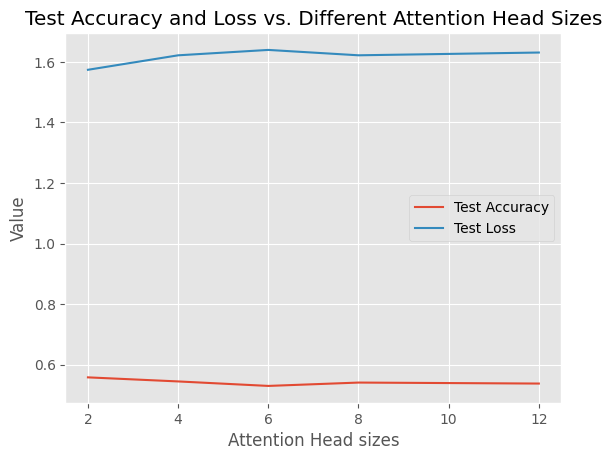

In [43]:
plt.plot(head_list, test_acc_list_headwise, label='Test Accuracy')
plt.plot(head_list, test_loss_list_headwise, label='Test Loss')
plt.xlabel('Attention Head sizes')
plt.ylabel('Value')
plt.title('Test Accuracy and Loss vs. Different Attention Head Sizes')
plt.legend()
plt.show()

# Experiment 4

### CLS Token from different Layers

In [44]:
class ViTforToekns(nn.Module):
    def __init__(self,img_size , patch_size, in_channel , emb_size  ,num_head , overlap):
        super().__init__()
        if overlap:
            self.patchEmb = PatchEmbeddingOverlapping( img_size,patch_size,in_channel , emb_size)
        else:
            self.patchEmb = PatchEmbedding( img_size,patch_size,in_channel , emb_size)

        self.cls_token = nn.Parameter(torch.zeros(1,1,emb_size))
        self.blocks = nn.ModuleList(
            [
                ResidualBlock(dim = emb_size , num_head = num_head)
                for _ in range(4)
            ]
        )
        self.pos_emb = nn.Parameter(
            torch.zeros(1,1+self.patchEmb.nf_patch ,emb_size)
        )
        self.norm = nn.LayerNorm(emb_size , eps = 1e-6)
        self.head = nn.Sequential(
            nn.Linear(emb_size, 10), #emv_size
            nn.Tanh()
        )
        
    def forward(self,x):
        n_sample = x.shape[0]
        x = self.patchEmb(x)
        cls_token = self.cls_token.expand(n_sample,-1,-1)
        
        x = torch.cat((cls_token,x),dim=1)
        x = x + self.pos_emb
        
        self.classes_list = []
        
        for block in self.blocks:
            x = block(x)
            self.classes_list.append(self.head(x[:,0]))
            
            
        x = self.norm(x)
        cls_token_final = x[:,0]
        x = self.head(cls_token_final)
        return x
    
    def classeslist(self):
        return self.classes_list

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  
model = ViTforToekns(32,16,3,768,12,False).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00009)

train_loss_list = []
train_acc_list = [] 
train_layerwise_acc_list = [[] for i in range(4)]

train_loss = 0
train_acc = 0 
train_layerwise_acc = [0 for i in range(4)]


for epochs in range(25):
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        cls_list = model.classeslist()
        for i in range(4):
            cls_pred = torch.argmax(torch.softmax(cls_list[i], dim=1), dim=1)
            train_layerwise_acc[i] += (cls_pred == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    for i in range(4):
        train_layerwise_acc[i] = train_layerwise_acc[i]/len(train_dataloader)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    for i in range(4):
        train_layerwise_acc_list[i].append(train_layerwise_acc[i])
    
  

    
    
  



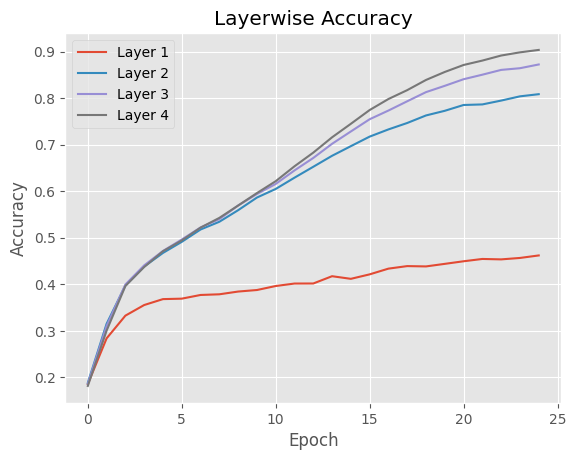

In [47]:
import matplotlib.pyplot as plt

num_epochs = len(train_acc_list)

for i in range(4):
    layerwise_acc = train_layerwise_acc_list[i]
    plt.plot(range(num_epochs), layerwise_acc, label=f'Layer {i+1}')

plt.title('Layerwise Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()


# Test Accuracy Layerwise

In [48]:
test_loss = 0
test_acc = 0
layerwise_acc = [0 for i in range(4)]

model.eval() 

with torch.no_grad(): 
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        test_loss += loss.item() 

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        test_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        cls_list = model.classeslist()
        for i in range(4):
            cls_pred = torch.argmax(torch.softmax(cls_list[i], dim=1), dim=1)
            layerwise_acc[i] += (cls_pred == y).sum().item()/len(y_pred)
            
                        
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)

for i in range(4):
    layerwise_acc[i] = layerwise_acc[i]/len(test_dataloader)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print(layerwise_acc)


Test Loss: 1.66305867780613
Test Accuracy: 0.5198773734177216
[0.3515625, 0.5126582278481012, 0.5255142405063291, 0.5194818037974683]


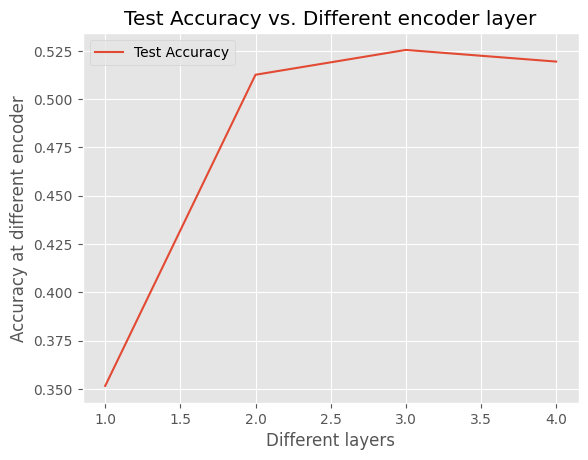

In [49]:
plt.plot([1,2,3,4], layerwise_acc, label='Test Accuracy')
plt.xlabel('Different layers')
plt.ylabel('Accuracy at different encoder')
plt.title('Test Accuracy vs. Different encoder layer')
plt.legend()
plt.show()